In [2]:
%run utilspro.py

In [3]:
# Loading the dataset
data = pd.read_csv(dataset_path)

# Displaying the first few rows of the dataset
data.head()

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at
0,INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
1,INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
2,INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
3,INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
4,INC0000047,New,True,0,0,0,True,Caller 2403,Opened by 397,29/2/2016 04:40,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 81,1/3/2016 09:52,6/3/2016 10:00


### Data Cleaning Steps:
- Handle placeholder values (?).
- Convert date columns to the proper datetime format.
- Address the inconsistency with incidents marked as active but having a closed_at date.
- Handle any other anomalies and inconsistencies identified during the EDA.

#### Handling placeholder values (?)
We previously identified several columns containing the placeholder value ?. We'll replace these placeholders with appropriate NaN (null) values, which will allow us to handle them more effectively.

In [4]:
# Replacing '?' with NaN
data.replace('?', pd.NA, inplace=True)

# Checking the number of missing values in each column after replacement
missing_values = data.isna().sum()

missing_values[missing_values > 0]

caller_id               29
opened_by             4835
sys_created_by       53076
sys_created_at       53076
location                76
category                78
subcategory            111
u_symptom            32964
cmdb_ci             141267
assignment_group     14213
assigned_to          27496
problem_id          139417
rfc                 140721
vendor              141468
caused_by           141689
closed_code            714
resolved_by            226
resolved_at           3141
dtype: int64

### Model Based imputation

Given that the KNN imputer may generate new labels not seen during the initial label encoding, we need to ensure that, post-imputation, only the known labels are used for inverse transformation.

strategy:

Using the KNN imputer on the data as before.
Post-imputation, for the columns that were label-encoded, clip any values that lie outside the range [0, number of classes for that column - 1].
Use inverse transformation on these clipped values.

In [5]:
missing_values_cleaned_updated=missing_values[missing_values > 0]

In [6]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer

# Selecting columns with missing values
columns_with_missing = missing_values_cleaned_updated.index.tolist()

# Creating a subset of data with these columns
data_missing = data.copy()[columns_with_missing]

# Label Encoding for categorical variables
label_encoders = {}
for col in columns_with_missing:
    if data_missing[col].dtype == 'object':
        le = LabelEncoder()
        data_missing[col] = le.fit_transform(data_missing[col].astype(str))
        label_encoders[col] = le

# Scaling the data for KNN
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_missing)

# Scaling the data for KNN
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_missing)

# KNN Imputer initialization and imputation
knn_imputer = KNNImputer(n_neighbors=5)
data_imputed = knn_imputer.fit_transform(data_scaled)

# Convert imputed data back to dataframe
data_imputed_df = pd.DataFrame(data_imputed, columns=columns_with_missing)

# Clipping values for label encoded columns to ensure they lie within the known labels range
for col, le in label_encoders.items():
    max_label = len(le.classes_) - 1
    data_imputed_df[col] = data_imputed_df[col].clip(0, max_label).astype(int)

    # Inverse transform for label encoded columns
    data_imputed_df[col] = le.inverse_transform(data_imputed_df[col])

# Checking if missing values are imputed and if any unknown labels were introduced
missing_after_imputation = data_imputed_df.isna().sum()

missing_after_imputation
#check the number of columns before and after imputation
print('Number of columns before imputation: ', data.shape[1])
print('Number of columns after imputation: ', data_imputed_df.shape[1])

# Replacing the columns in the original dataset with the imputed versions
data_cleaning = data.copy()
for col in columns_with_missing:
    data_cleaning[col] = data_imputed_df[col]

# Checking the number of columns after the replacement
num_columns_after_replacement = data_cleaning.shape[1]

print('Number of columns after replacement', num_columns_after_replacement)

data_cleaning.isna().sum()


Number of columns before imputation:  36
Number of columns after imputation:  18
Number of columns after replacement 36


number                     0
incident_state             0
active                     0
reassignment_count         0
reopen_count               0
sys_mod_count              0
made_sla                   0
caller_id                  0
opened_by                  0
opened_at                  0
sys_created_by             0
sys_created_at             0
sys_updated_by             0
sys_updated_at             0
contact_type               0
location                   0
category                   0
subcategory                0
u_symptom                  0
cmdb_ci                    0
impact                     0
urgency                    0
priority                   0
assignment_group           0
assigned_to                0
knowledge                  0
u_priority_confirmation    0
notify                     0
problem_id                 0
rfc                        0
vendor                     0
caused_by                  0
closed_code                0
resolved_by                0
resolved_at   

In [7]:
data_cleaning.columns

Index(['number', 'incident_state', 'active', 'reassignment_count',
       'reopen_count', 'sys_mod_count', 'made_sla', 'caller_id', 'opened_by',
       'opened_at', 'sys_created_by', 'sys_created_at', 'sys_updated_by',
       'sys_updated_at', 'contact_type', 'location', 'category', 'subcategory',
       'u_symptom', 'cmdb_ci', 'impact', 'urgency', 'priority',
       'assignment_group', 'assigned_to', 'knowledge',
       'u_priority_confirmation', 'notify', 'problem_id', 'rfc', 'vendor',
       'caused_by', 'closed_code', 'resolved_by', 'resolved_at', 'closed_at'],
      dtype='object')

In [8]:
# Converting date columns to datetime format
date_columns = ['opened_at', 'sys_created_at', 'resolved_at', 'closed_at']
for column in date_columns:
    data_cleaning[column] = data_cleaning[column].apply(robust_date_parser)

# Checking the datatypes of the columns after conversion
data_cleaning[date_columns].dtypes


opened_at         datetime64[ns]
sys_created_at    datetime64[ns]
resolved_at       datetime64[ns]
closed_at         datetime64[ns]
dtype: object

Let's address the anomalies and inconsistencies we identified during our exploratory data analysis (EDA):

- Incidents with closed_at dates but marked as active: 
We found 116,726 such incidents. This is inconsistent since active incidents should not have a closure date.
- Potential Outliers:
Reassignment Count: Some incidents have been reassigned more than 20 times.
- Reopen Count: 
Some incidents have been reopened multiple times.
- Sys Mod Count: 
Some incidents have more than 40 system modifications.

### Addressing Anomalies:
- Incidents with closed_at dates but marked as active:
### Our solution: Set these incidents as inactive (active = False).

- Potential Outliers:
For each of the columns (Reassignment Count, Reopen Count, Sys Mod Count), we can:
a. Cap the values at a certain threshold based on domain knowledge or statistical measures (like the 95th percentile).
b. Investigate further to understand the reasons for such high values.
c. Leave them as they are if they represent genuine scenarios.

In [10]:
# Setting incidents with 'closed_at' dates but marked as 'active' to inactive
data_cleaning.loc[(data_cleaning['active'] == True) & (data_cleaning['closed_at'].notna()), 'active'] = False

# Checking the number of incidents that are still marked as 'active' but have a 'closed_at' date
active_with_closed_date = data_cleaning[(data_cleaning['active'] == True) & (data_cleaning['closed_at'].notna())].shape[0]

active_with_closed_date

0

### Potential Outliers:

For columns : Reassignment Count, Reopen Count, and Sys Mod Count, we can cap values beyond the 0.95 quantile threshold as follows:

In [11]:
columns_list = ['reassignment_count', 'reopen_count', 'sys_mod_count']
for column in columns_list:
    threshold = data_cleaning[column].quantile(0.95)
    data_cleaning[column] = data_cleaning[column].apply(lambda x: threshold if x > threshold else x)

## Feature engineering
- Date Features: Extract relevant information from date columns.
Day of the week, hour, and month from the opened_at column.
Time taken to resolve an incident (difference between closed_at and opened_at).

- Categorical Features: Convert categorical variables into a format suitable for machine learning models.
One-hot encode categorical columns like incident_state, contact_type, and priority.
For high cardinality categorical columns, consider using target encoding or other encoding techniques.

- Text Features: If there are textual descriptions or notes in the dataset, derive features from them.
Text length, sentiment analysis, or even more advanced techniques like TF-IDF or embeddings (this would depend on the nature and quality of the text data).

- Interaction Features: Create interaction terms between relevant features, which can sometimes capture patterns that individual features might miss.

- Normalization: Depending on the model we decide to use later, we might need to normalize or standardize some numerical features.

Let's start by extracting features from the date columns, specifically from the opened_at column. We'll derive the day of the week, hour, and month from it.

In [12]:
# Extracting features from the 'opened_at' column
data_cleaning['opened_day_of_week'] = data_cleaning['opened_at'].dt.dayofweek
data_cleaning['opened_hour'] = data_cleaning['opened_at'].dt.hour
data_cleaning['opened_month'] = data_cleaning['opened_at'].dt.month

# Calculating the resolution time in hours (if it hasn't been calculated already)
if 'resolution_time' not in data_cleaning.columns:
    data_cleaning['resolution_time'] = (data_cleaning['closed_at'] - data_cleaning['opened_at']).dt.total_seconds() / (60 * 60)

# Displaying the first few rows with the new features
data_cleaning[['opened_at', 'opened_day_of_week', 'opened_hour', 'opened_month', 'resolution_time']].head()


,opened_at,opened_day_of_week,opened_hour,opened_month,resolution_time
0,2016-02-29 01:16:00,0,1,2,130.733333
1,2016-02-29 01:16:00,0,1,2,130.733333
2,2016-02-29 01:16:00,0,1,2,130.733333
3,2016-02-29 01:16:00,0,1,2,130.733333
4,2016-02-29 04:40:00,0,4,2,149.333333


In [13]:
# Calculating the resolution duration in hours
data_cleaning['resolution_duration'] = (data_cleaning['closed_at'] - data_cleaning['opened_at']).dt.total_seconds() / 3600

# Displaying the first few rows with the 'resolution_duration' feature
data_cleaning[['opened_at', 'closed_at', 'resolution_duration']].head()

,opened_at,closed_at,resolution_duration
0,2016-02-29 01:16:00,2016-03-05 12:00:00,130.733333
1,2016-02-29 01:16:00,2016-03-05 12:00:00,130.733333
2,2016-02-29 01:16:00,2016-03-05 12:00:00,130.733333
3,2016-02-29 01:16:00,2016-03-05 12:00:00,130.733333
4,2016-02-29 04:40:00,2016-03-06 10:00:00,149.333333


#### Checking for duplicated entries

In [14]:
# Check for duplicates
data_cleaning.duplicated().sum()

279

In [18]:
# display the duplicated rows and make a list out  of the 'number' column values
duplicated_rows = data_cleaning[data_cleaning.duplicated(keep=False)].sort_values(by='number')
duplicated_rows['number'].tolist()

['INC0000197',
 'INC0000197',
 'INC0000403',
 'INC0000403',
 'INC0000783',
 'INC0000783',
 'INC0000824',
 'INC0000824',
 'INC0000988',
 'INC0000988',
 'INC0000990',
 'INC0000990',
 'INC0001041',
 'INC0001041',
 'INC0001348',
 'INC0001348',
 'INC0001349',
 'INC0001349',
 'INC0001471',
 'INC0001471',
 'INC0001649',
 'INC0001649',
 'INC0001760',
 'INC0001760',
 'INC0001929',
 'INC0001929',
 'INC0002129',
 'INC0002129',
 'INC0002129',
 'INC0002129',
 'INC0002129',
 'INC0002299',
 'INC0002299',
 'INC0002375',
 'INC0002375',
 'INC0002375',
 'INC0002375',
 'INC0002437',
 'INC0002437',
 'INC0002528',
 'INC0002528',
 'INC0002780',
 'INC0002780',
 'INC0002804',
 'INC0002804',
 'INC0003045',
 'INC0003045',
 'INC0003140',
 'INC0003140',
 'INC0003140',
 'INC0003140',
 'INC0003150',
 'INC0003150',
 'INC0003150',
 'INC0003150',
 'INC0003237',
 'INC0003237',
 'INC0003256',
 'INC0003256',
 'INC0003256',
 'INC0003256',
 'INC0003300',
 'INC0003300',
 'INC0003419',
 'INC0003419',
 'INC0003419',
 'INC00034

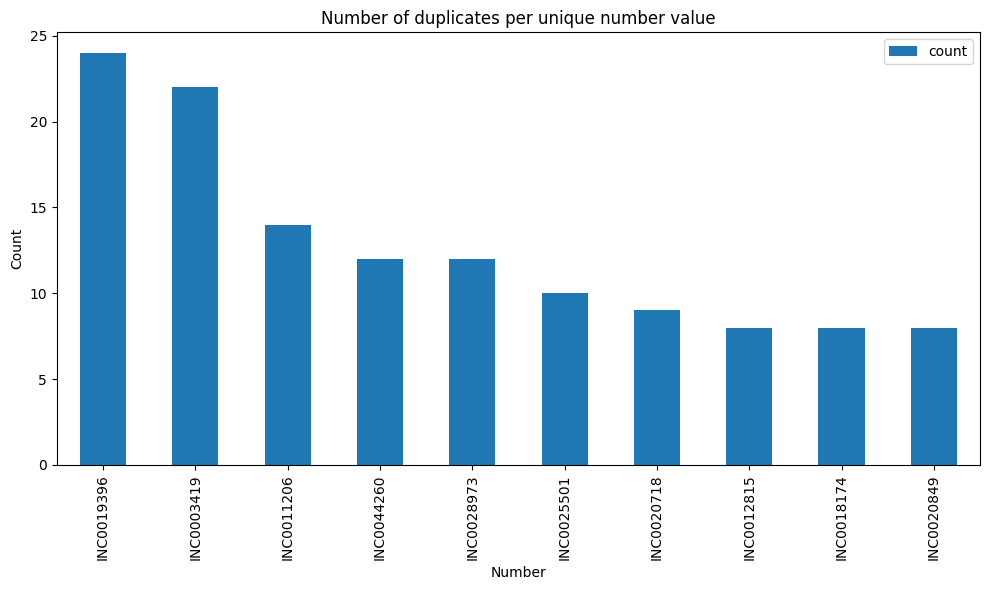

In [23]:
# make a dataframe with the duplicated rows stating the number of duplicates per unique number value
duplicated_rows_count = duplicated_rows.groupby('number').size().reset_index(name='count')
# plot the most numeros duplicated rows count in a descending order
duplicated_rows_count.sort_values(by='count', ascending=False).head(10).plot.bar(x='number', y='count', figsize=(10, 6))
#label the plot
plt.title('Number of duplicates per unique number value')
plt.xlabel('Number')
plt.ylabel('Count')
plt.tight_layout()
plt.show()



In [39]:
# check the high cardinality categorigal column
categorical_columns = data_cleaning.select_dtypes(include=['object']).columns.tolist()
high_cardinality_categorical_columns = []
for column in categorical_columns:
    #check the high cardinality categorigal column
    if data_cleaning[column].nunique() > 10:
        high_cardinality_categorical_columns.append(column)
        print(column, data_cleaning[column].nunique())
        print('\n')


number 24918


sys_updated_by 846


sys_updated_at 50664


cmdb_ci 30


problem_id 14


rfc 20




In [41]:
data_cleaning.head()
bypass_columns = ['number', 'opened_at', 'sys_created_at', 'resolved_at', 'closed_at', 'resolution_time', 'resolution_duration']

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,caused_by,closed_code,resolved_by,resolved_at,closed_at,opened_day_of_week,opened_hour,opened_month,resolution_time,resolution_duration
0,INC0000045,New,False,0.0,0.0,0.0,True,<NA>,Opened by 10,2016-02-29 01:16:00,...,<NA>,<NA>,<NA>,2017-01-01 01:17:00,2016-03-05 12:00:00,0,1,2,130.733333,130.733333
1,INC0000045,Resolved,False,0.0,0.0,2.0,True,<NA>,Opened by 10,2016-02-29 01:16:00,...,<NA>,<NA>,<NA>,2017-01-01 01:17:00,2016-03-05 12:00:00,0,1,2,130.733333,130.733333
2,INC0000045,Resolved,False,0.0,0.0,3.0,True,<NA>,Opened by 10,2016-02-29 01:16:00,...,<NA>,<NA>,<NA>,2017-01-01 01:17:00,2016-03-05 12:00:00,0,1,2,130.733333,130.733333
3,INC0000045,Closed,False,0.0,0.0,4.0,True,<NA>,Opened by 10,2016-02-29 01:16:00,...,<NA>,<NA>,<NA>,2017-01-01 01:17:00,2016-03-05 12:00:00,0,1,2,130.733333,130.733333
4,INC0000047,New,False,0.0,0.0,0.0,True,<NA>,<NA>,2016-02-29 04:40:00,...,<NA>,<NA>,Resolved by 10,2017-01-01 01:17:00,2016-03-06 10:00:00,0,4,2,149.333333,149.333333


In [40]:
high_cardinality_categorical_columns

['number', 'sys_updated_by', 'sys_updated_at', 'cmdb_ci', 'problem_id', 'rfc']